In [1]:
import pandas as pd

In [2]:
import os
cur = os.getcwd()
print(cur)

c:\qtri\Purdue\Pengyi Shi\MLAI in healthcare\Generative-AI-and-LLM-in-Healthcare-Operations\Integration


## MODEL 1.1 - binary, cap (before data engineer and cost multiplcation)

In [3]:
#my_csv = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_no_cap_continuous_2.csv")
myDF_capped = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_cap (1).csv")

In [16]:
myDF_capped.drop(['ocp_wr_low_los', 'ocp_jl_low_los', 'ocp_hd_low_los'], axis=1, inplace=True) 

In [17]:
# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in myDF_capped.iterrows():
    if item['placement'] == 'work release':
        myDF_capped['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        myDF_capped['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        myDF_capped['placement'].iat[ind] = '2'

#object to int
myDF_capped['placement'] = pd.to_numeric(myDF_capped['placement'])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
y = myDF_capped["placement"]
X = myDF_capped.drop(["placement"], axis = 1)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split( X, y, train_size = 0.7, random_state = 50) 

In [10]:
rf2a = RandomForestClassifier(max_depth= 7, max_features = 'sqrt', min_samples_leaf = 5, 
 min_samples_split = 5, n_estimators = 100, random_state= 50) 
rf2a.fit(X_train_1, y_train_1) 

RandomForestClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=5,
                       random_state=50)

In [11]:
y_preda = rf2a.predict(X_test_1)
from sklearn.metrics import roc_auc_score
print('roc_auc_score: ' + str(roc_auc_score(y_test_1, rf2a.predict_proba(X_test_1), multi_class='ovr' )))

roc_auc_score: 0.8084761353674598


In [12]:
import shap
# binary nocap dataset, 25 features, without data engineer
explainer = shap.TreeExplainer(rf2a)
shap_values1 = explainer(X_train_1)

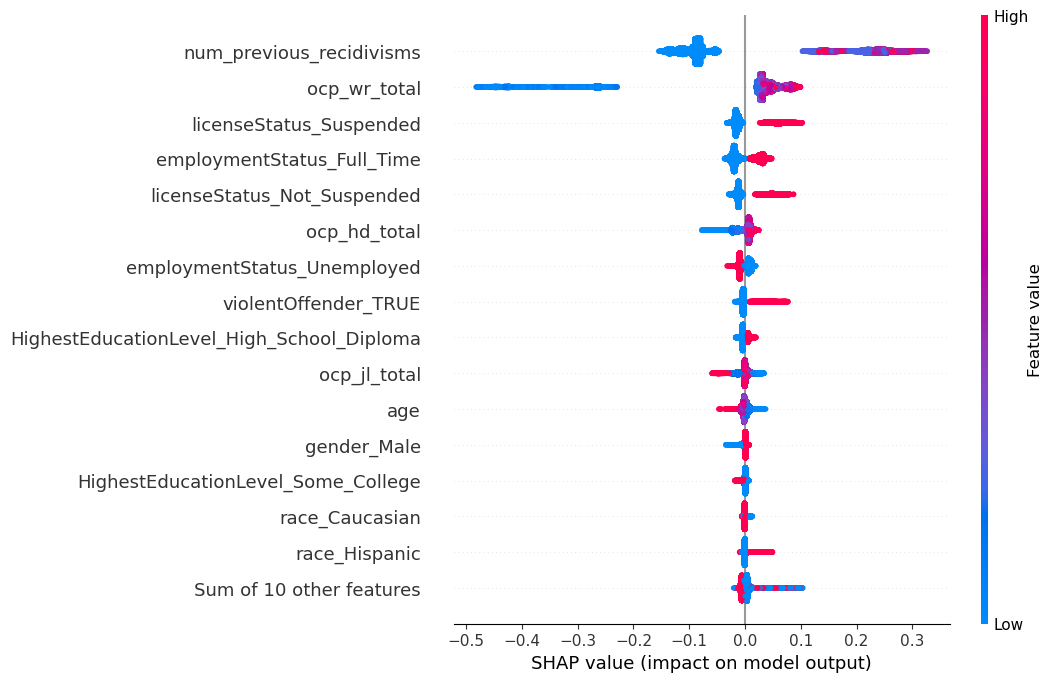

In [48]:
shap.plots.beeswarm(shap_values1[:,:,2], max_display= 16)

## Model 1.2 Binary, no_cap (before data engineer and cost multiplication).

In [19]:
#my_csv = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_no_cap_continuous_2.csv")
myDF_no_capped = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_no_cap.csv")

In [ ]:
myDF_no_capped.drop(['ocp_wr_low_los', 'ocp_jl_low_los', 'ocp_hd_low_los'], axis=1, inplace=True) 

# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in myDF_no_capped.iterrows():
    if item['placement'] == 'work release':
        myDF_no_capped['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        myDF_no_capped['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        myDF_no_capped['placement'].iat[ind] = '2'

#object to int
myDF_no_capped['placement'] = pd.to_numeric(myDF_no_capped['placement'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = myDF_no_capped["placement"]
X = myDF_no_capped.drop(["placement"], axis = 1)
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split( X, y, train_size = 0.7, random_state = 50) 

rf_model12 = RandomForestClassifier(max_depth= 7, max_features = 'sqrt', min_samples_leaf = 5, 
 min_samples_split = 5, n_estimators = 100, random_state= 50) 
rf_model12.fit(X_train_12, y_train_12) 

y_pred_12 = rf_model12.predict(X_test_12)
from sklearn.metrics import roc_auc_score
print('roc_auc_score: ' + str(roc_auc_score(y_test_12, rf_model12.predict_proba(X_test_12), multi_class='ovr' )))

roc_auc_score: 0.8461207331196229


In [22]:
import shap
# binary nocap dataset, 25 features, without data engineer
explainer_12 = shap.TreeExplainer(rf_model12)
shap_values_12 = explainer_12(X_train_12)

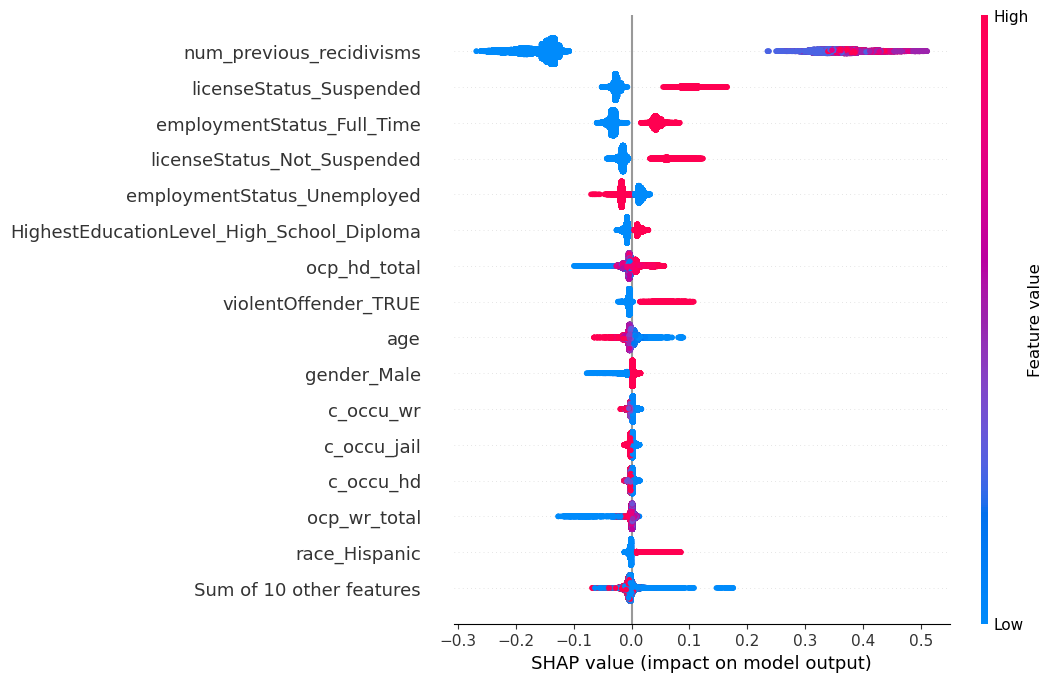

In [50]:
shap.plots.beeswarm(shap_values_12[:,:,2], max_display= 16) 

## MODEL 2.1 - Binary, no-cap (After Data Engineer)

In [17]:
my_csv2 = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_no_cap.csv")
#myDF_no_capped = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_no_cap.csv")
unknown_employment_index = my_csv2[ (my_csv2['employmentStatus_Full_Time'] == 0) & (my_csv2['employmentStatus_Part_Time'] == 0) & (my_csv2['employmentStatus_Unemployed'] == 0)].index
unknown_employment_age = my_csv2[ (my_csv2['employmentStatus_Part_Time'] == 0) & (my_csv2['employmentStatus_Unemployed'] == 0) & (my_csv2['employmentStatus_Full_Time'] == 0) ]['age']
unemployment_index = my_csv2[ my_csv2['employmentStatus_Unemployed'] == 1].index
unknown_employment_index

type1_index = list(unemployment_index) + list(unknown_employment_index)
type2_index = list(my_csv2[ my_csv2['employmentStatus_Full_Time'] == 1].index) + list(my_csv2[ my_csv2['employmentStatus_Part_Time'] == 1].index)
new_row = [0] * my_csv2.shape[0]
for index in type1_index:
    new_row[index] = 1

my_csv2['Employed'] = new_row
my_csv2.drop(['employmentStatus_Part_Time', 'employmentStatus_Full_Time'], axis =1, inplace = True )
new_row = [0] * my_csv2.shape[0]
for index in type2_index:
    new_row[index] = 1

my_csv2['Unemployed'] = new_row
my_csv2.drop(['employmentStatus_Unemployed'], axis =1, inplace = True )
my_csv2.drop(['Unemployed', 'ocp_wr_low_los', 'ocp_jl_low_los', 'ocp_hd_low_los','licenseStatus_Not_Suspended','licenseStatus_Suspended'], axis=1, inplace=True) 

In [18]:
# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in my_csv2.iterrows():
    if item['placement'] == 'work release':
        my_csv2['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        my_csv2['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        my_csv2['placement'].iat[ind] = '2'

#object to int
my_csv2['placement'] = pd.to_numeric(my_csv2['placement'])

In [19]:
my_csv2['weighted_jl_total'] = my_csv2['c_occu_jail']*my_csv2['ocp_jl_total']
my_csv2['weighted_wr_total'] = my_csv2['c_occu_wr']*my_csv2['ocp_wr_total']
my_csv2['weighted_hd_total'] = my_csv2['c_occu_hd']*my_csv2['ocp_hd_total']
my_csv2.drop(['c_occu_jail', 'c_occu_wr', 'c_occu_hd', 'ocp_jl_total', 'ocp_wr_total', 'ocp_hd_total'], axis = 1, inplace=True)

## XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
y = my_csv2["placement"]
X = my_csv2.drop(["placement"], axis = 1)
X_train2, X_test2, y_train2, y_test2 = train_test_split( X, y, train_size = 0.7, random_state = 50) 

In [ ]:
gbf_test = GradientBoostingClassifier()

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
param_grid = {'n_estimators': [100,150,200], 'max_depth': [1, 5], 'learning_rate': [0.5, 1]}
sh = HalvingGridSearchCV(gbf_test, param_grid, cv = 5, factor = 2, random_state=50).fit(X_train2, y_train2)

In [ ]:
sh.best_params_

{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200}

In [ ]:
gbf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.5, max_depth = 5, random_state= 42).fit(X_train2, y_train2)
y_pred2 = gbf.predict(X_test2)
from sklearn.metrics import roc_auc_score
print('roc_auc_score: ' + str(roc_auc_score(y_test2, gbf.predict_proba(X_test2), multi_class='ovr' )))

roc_auc_score: 0.9882667700655237


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
y = my_csv2["placement"]
X = my_csv2.drop(["placement"], axis = 1)
X_train2, X_test2, y_train2, y_test2 = train_test_split( X, y, train_size = 0.7, random_state = 50) 
rf2a_gbf = RandomForestClassifier(max_depth= 5, max_features = 'sqrt', min_samples_leaf = 5, 
 min_samples_split = 5, n_estimators = 100, random_state= 50) 
#rf2a = RandomForestClassifier(max_depth= None, max_features = 'sqrt', min_samples_leaf = 2,
# min_samples_split = 2, n_estimators = 230, random_state= 50) # --> 0.94
rf2a_gbf.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5,
                       random_state=50)

In [7]:
len(X_train2.columns)

18

In [ ]:
import shap
# binary, after data engineer dataset and cost multiplication, 18 features (Correct)
explainer2 = shap.TreeExplainer(rf2a_gbf)
shap_values_2 = explainer2(X_train2)
# shap.plots.beeswarm(shap_values_2[:,:,0], max_display = 16) # Work Release, binary, nocap
# shap.plots.beeswarm(shap_values_2[:,:,1], max_display = 16) # Home Detention, binary, nocap 
# shap.plots.beeswarm(shap_values_2[:,:,2], max_display = 16) # Jail, binary, nocap 

In [39]:
shap_values_2.values[0].shape

(18, 3)

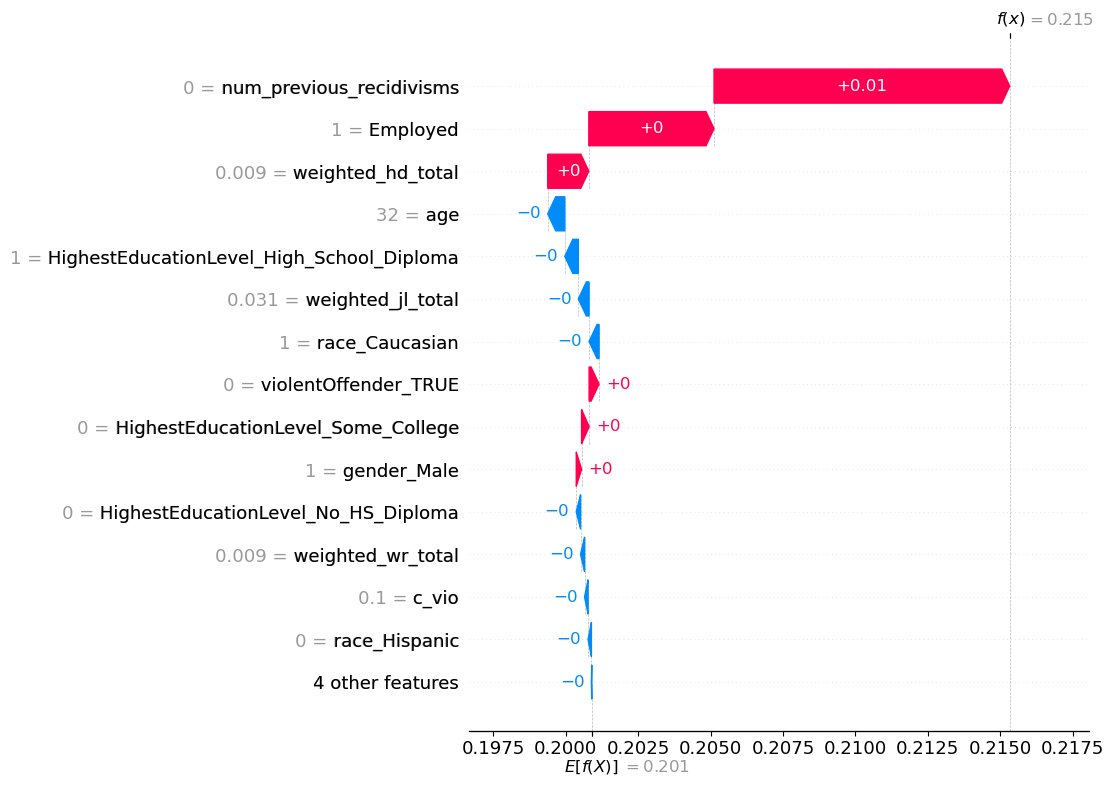

In [64]:
shap.plots.waterfall(shap_values_2[0,:,1], max_display= 15)

## Model 2.2 - Binary, cap (after employment data adjustment)

In [ ]:
my_csv_22 = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_cap.csv")
#myDF_no_capped = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_no_cap.csv")
unknown_employment_index = my_csv_22[ (my_csv_22['employmentStatus_Full_Time'] == 0) & (my_csv_22['employmentStatus_Part_Time'] == 0) & (my_csv_22['employmentStatus_Unemployed'] == 0)].index
unknown_employment_age = my_csv_22[ (my_csv_22['employmentStatus_Part_Time'] == 0) & (my_csv_22['employmentStatus_Unemployed'] == 0) & (my_csv_22['employmentStatus_Full_Time'] == 0) ]['age']
unemployment_index = my_csv_22[ my_csv_22['employmentStatus_Unemployed'] == 1].index
unknown_employment_index

type1_index = list(unemployment_index) + list(unknown_employment_index)
type22_index = list(my_csv_22[ my_csv_22['employmentStatus_Full_Time'] == 1].index) + list(my_csv_22[ my_csv_22['employmentStatus_Part_Time'] == 1].index)
new_row = [0] * my_csv_22.shape[0]
for index in type1_index:
    new_row[index] = 1

my_csv_22['Employed'] = new_row
my_csv_22.drop(['employmentStatus_Part_Time', 'employmentStatus_Full_Time'], axis =1, inplace = True )
new_row = [0] * my_csv_22.shape[0]
for index in type22_index:
    new_row[index] = 1

my_csv_22['Unemployed'] = new_row
my_csv_22.drop(['employmentStatus_Unemployed'], axis =1, inplace = True )
my_csv_22.drop([ 'ocp_wr_low_los', 'ocp_jl_low_los', 'ocp_hd_low_los','licenseStatus_Not_Suspended','licenseStatus_Suspended'], axis=1, inplace=True) 


In [5]:
# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in my_csv_22.iterrows():
    if item['placement'] == 'work release':
        my_csv_22['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        my_csv_22['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        my_csv_22['placement'].iat[ind] = '2'

#object to int
my_csv_22['placement'] = pd.to_numeric(my_csv_22['placement'])

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y_22 = my_csv_22["placement"]
X_22 = my_csv_22.drop(["placement"], axis = 1)
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split( X_22, y_22, train_size = 0.7, random_state = 50) 

rf_model22 = RandomForestClassifier(max_depth= 7, max_features = 'sqrt', min_samples_leaf = 5, 
 min_samples_split = 5, n_estimators = 100, random_state= 50) 
rf_model22.fit(X_train_22, y_train_22) 

y_pred_22 = rf_model22.predict(X_test_22)
from sklearn.metrics import roc_auc_score
print('roc_auc_score: ' + str(roc_auc_score(y_test_22, rf_model22.predict_proba(X_test_22), multi_class='ovr' )))

roc_auc_score: 0.8394335156436168


In [7]:
import shap
# binary cap dataset, 22 features, without data engineer
explainer_22 = shap.TreeExplainer(rf_model22)
shap_values_22 = explainer_22(X_train_22)

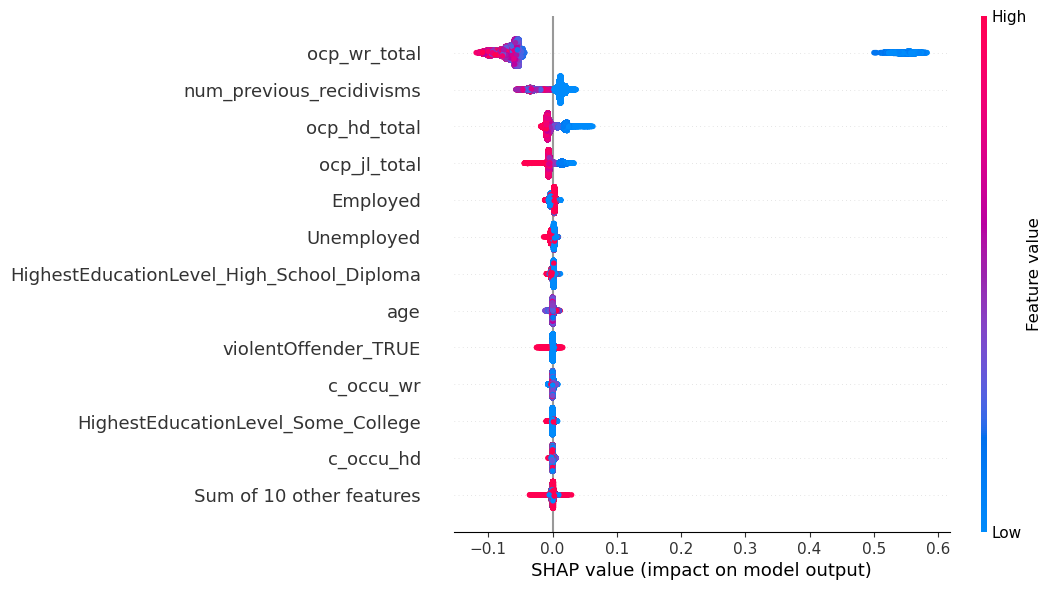

In [ ]:
# binary, cap, after employment data adjustment
shap.plots.beeswarm(shap_values_22[:,:,0], max_display = 13)

## Model 3 - Continous, no_Cap (after data engineer and cost multiplcation)

In [10]:
my_csv = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_no_cap_continuous_2.csv")

unknown_employment_index = my_csv[ (my_csv['employmentStatus_Full_Time'] == 0) & (my_csv['employmentStatus_Part_Time'] == 0) & (my_csv['employmentStatus_Unemployed'] == 0)].index
unknown_employment_age = my_csv[ (my_csv['employmentStatus_Part_Time'] == 0) & (my_csv['employmentStatus_Unemployed'] == 0) & (my_csv['employmentStatus_Full_Time'] == 0) ]['age']
unemployment_index = my_csv[ my_csv['employmentStatus_Unemployed'] == 1].index
unknown_employment_index

type1_index = list(unemployment_index) + list(unknown_employment_index)
type2_index = list(my_csv[ my_csv['employmentStatus_Full_Time'] == 1].index) + list(my_csv[ my_csv['employmentStatus_Part_Time'] == 1].index)
new_row = [0] * my_csv.shape[0]
for index in type1_index:
    new_row[index] = 1

my_csv['Employed'] = new_row
my_csv.drop(['employmentStatus_Part_Time', 'employmentStatus_Full_Time'], axis =1, inplace = True )

new_row = [0] * my_csv.shape[0]
for index in type2_index:
    new_row[index] = 1

my_csv['Unemployed'] = new_row
my_csv.drop(['employmentStatus_Unemployed'], axis =1, inplace = True )
my_csv.drop(['Unemployed','ocp_wr_low_los', 'ocp_jl_low_los', 'ocp_hd_low_los','licenseStatus_Not_Suspended','licenseStatus_Suspended'], axis=1, inplace=True) 

### Occupancy times Costs

In [11]:
my_csv['weighted_jl_total'] = my_csv['c_occu_jail']*my_csv['ocp_jl_total']
my_csv['weighted_wr_total'] = my_csv['c_occu_wr']*my_csv['ocp_wr_total']
my_csv['weighted_hd_total'] = my_csv['c_occu_hd']*my_csv['ocp_hd_total']
my_csv.drop(['c_occu_jail', 'c_occu_wr', 'c_occu_hd', 'ocp_jl_total', 'ocp_wr_total', 'ocp_hd_total'], axis = 1, inplace=True)

In [12]:
# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in my_csv.iterrows():
    if item['placement'] == 'work release':
        my_csv['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        my_csv['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        my_csv['placement'].iat[ind] = '2'

#object to int
my_csv['placement'] = pd.to_numeric(my_csv['placement'])

In [21]:
#from sklearn.preprocessing import MinMaxScaler
#scale = MinMaxScaler()
#pre_num_scaled = pd.DataFrame(scale.fit_transform(my_csv[['num_previous_recidivisms']]), columns = ['scaled_prev'])

In [22]:
#my_csv['scaled_prev'] = pre_num_scaled
#my_csv.drop(['num_previous_recidivisms'], axis = 1, inplace = True)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [14]:
y = my_csv["placement"]
X = my_csv.drop(["placement"], axis = 1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size = 0.7, random_state = 50) 

In [50]:
rf3 = RandomForestClassifier(random_state= 50)
rf3.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
param_grid = {'n_estimators': [100,150,200, 230], 'max_depth': [None, 5, 10], 
              'min_samples_leaf': [2, 5, 10],
              'min_samples_split': [2, 4, 6], 'max_features': ["sqrt", "log2", None]}

In [28]:
#sh = HalvingGridSearchCV(rf3, param_grid, cv = 5, factor = 2, random_state=50).fit(X_train, y_train)

In [16]:
rf2a = RandomForestClassifier(max_depth= 5, max_features = 'sqrt', min_samples_leaf = 5, 
 min_samples_split = 5, n_estimators = 100, random_state= 50) 
#rf2a = RandomForestClassifier(max_depth= None, max_features = 'sqrt', min_samples_leaf = 2,
# min_samples_split = 2, n_estimators = 230, random_state= 50) # --> 0.94

In [39]:
#import pickle
#with open('demographic_occupancy_rf.pkl', 'wb') as file:
#    pickle.dump(rf2a, file)

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [18]:
rf2a.fit(X_train, y_train) 
y_preda = rf2a.predict(X_test)
from sklearn.metrics import roc_auc_score
print('roc_auc_score: ' + str(roc_auc_score(y_test, rf2a.predict_proba(X_test), multi_class='ovr' )))
print('f1_score: ' + str(f1_score(y_test, y_preda, average='weighted')))
print('precision_score: ' + str(precision_score(y_test, y_preda, average ='weighted')))
print('recall_score: ' + str(recall_score(y_test, y_preda, average ='weighted')))

roc_auc_score: 0.8464025607024116
f1_score: 0.6286913235631998
precision_score: 0.6496929037707639
recall_score: 0.7133265977903074


In [ ]:
# continuous nocap dataset, after data engineering with 18 features.
explainer_continuous = shap.TreeExplainer(rf2a)
shap_values_cont = explainer_continuous(X_train)
# shap.plots.beeswarm(shap_values_cont[:,:,0], max_display = 16) # Work Release, continuous, nocap
# shap.plots.beeswarm(shap_values_cont[:,:,1], max_display = 16) # Home Detention, cont, nocap
# shap.plots.beeswarm(shap_values_cont[:,:,2], max_display = 16) # Jail, cont, nocap

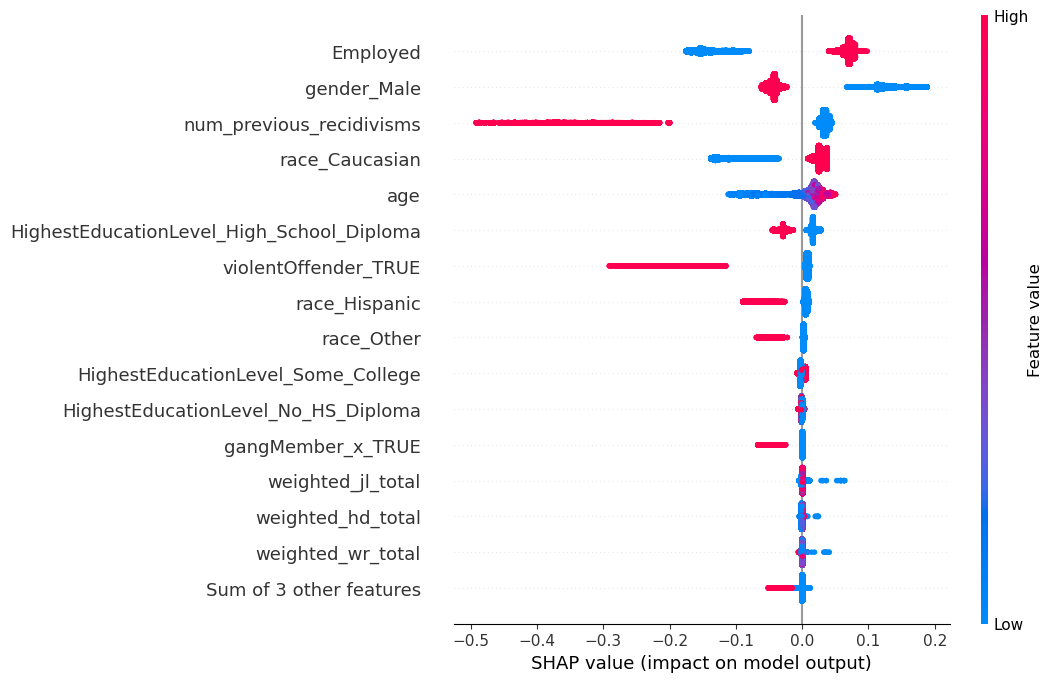

In [22]:
shap.plots.beeswarm(shap_values_cont[:,:,0], max_display = 16)

## 4.1 Continous, cap, before Feature Eng and Cost multiplcation

In [ ]:
myDF_cont_capped = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_no_cap.csv")
myDF_cont_capped.drop(['ocp_wr_low_los', 'ocp_jl_low_los', 'ocp_hd_low_los'], axis=1, inplace=True) 

# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in myDF_cont_capped.iterrows():
    if item['placement'] == 'work release':
        myDF_cont_capped['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        myDF_cont_capped['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        myDF_cont_capped['placement'].iat[ind] = '2'

#object to int
myDF_cont_capped['placement'] = pd.to_numeric(myDF_cont_capped['placement'])

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = myDF_cont_capped["placement"]
X = myDF_cont_capped.drop(["placement"], axis = 1)
X_train_41, X_test_41, y_train_41, y_test_41 = train_test_split( X, y, train_size = 0.7, random_state = 50) 

rf_model41 = RandomForestClassifier(max_depth= 7, max_features = 'sqrt', min_samples_leaf = 5, 
 min_samples_split = 5, n_estimators = 100, random_state= 50) 
rf_model41.fit(X_train_41, y_train_41) 

y_pred_41 = rf_model41.predict(X_test_41)
from sklearn.metrics import roc_auc_score
print('roc_auc_score: ' + str(roc_auc_score(y_test_41, rf_model41.predict_proba(X_test_41), multi_class='ovr' )))

roc_auc_score: 0.8461207331196229


In [46]:
import shap
# binary nocap dataset, 25 features, without data engineer
explainer_41 = shap.TreeExplainer(rf_model41)
shap_values_41 = explainer_41(X_train_41)

In [ ]:
shap.plots.beeswarm

## Recidivism ONLY

In [57]:
recid = pd.read_csv("..\dataset\clientTrajectory_JailUpdate.csv")

In [58]:
recid

,ProfileID,age,num_previous_recidivisms,race_Caucasian,race_Hispanic,race_Other,gender_Male,registeredSexOffender_TRUE,violentOffender_TRUE,gangMember_x_TRUE,...,ArrivalTime,WorkReleaseArrival,WorkReleaseDeparture,MonitoringArrival,MonitoringDeparture,HomeArrival,HomeDeparture,JailArrival,JailDeparture,Recidivism
0,0,42,0,1,0,0,1,0,0,0,...,0.007881,0.007881,0.236211,0.236211,5.467985,5.467985,19.350904,19.350904,22.350904,0
1,1,37,0,1,0,0,0,0,0,0,...,0.017360,0.017360,2.769589,NaN,NaN,2.769589,5.765856,5.765856,6.765856,0
2,2,62,0,0,1,0,1,0,0,0,...,0.033447,0.033447,1.721611,1.721611,3.700107,3.700107,11.915925,11.915925,16.915925,0
3,3,42,0,1,0,0,1,0,0,0,...,0.035496,0.035496,8.052818,8.052818,10.271917,10.271917,31.962209,31.962209,34.962209,0
4,4,43,0,1,0,0,1,0,0,0,...,0.036166,0.036166,0.280887,NaN,NaN,0.280887,2.425421,2.425421,10.425421,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50954,50954,53,0,1,0,0,0,0,0,0,...,899.876265,899.876265,899.964084,NaN,NaN,NaN,NaN,0.000000,3.000000,0
50955,50955,41,0,0,0,0,0,0,0,0,...,899.891829,899.891829,902.344845,NaN,NaN,NaN,NaN,0.000000,8.000000,0
50956,50956,29,0,1,0,0,0,0,0,0,...,899.907021,899.907021,905.382880,NaN,NaN,NaN,NaN,0.000000,4.000000,0
50957,50957,23,0,0,0,1,1,0,0,0,...,899.911229,899.911229,902.613586,NaN,NaN,NaN,NaN,0.000000,9.000000,0


## SHAP 

In [4]:
import pickle
explainer = pickle.load(open('explainer.pkl', 'rb'))

In [6]:
import shap

In [ ]:
shap_value_Nov10 = explainer(X_train)

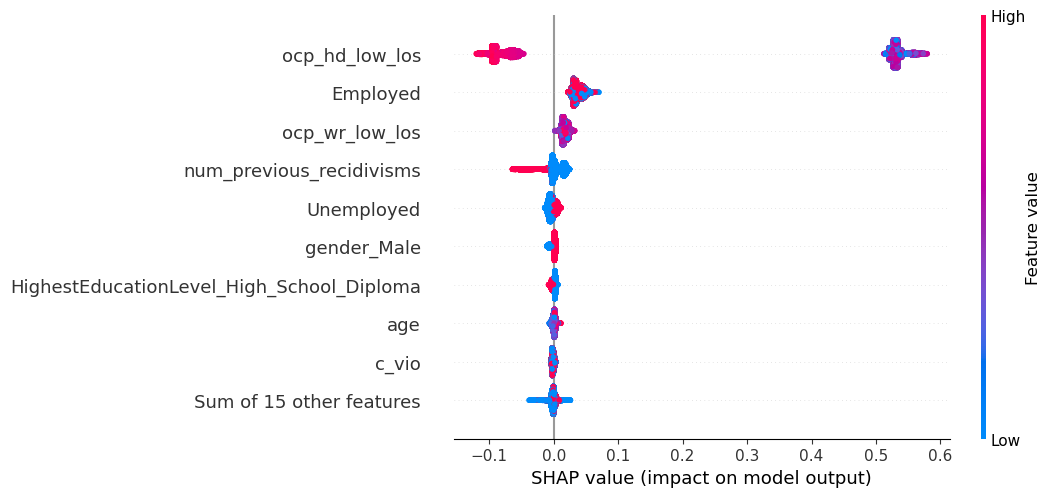

In [40]:
shap.plots.beeswarm(shap_value_Nov10[:,:,0])

In [19]:
explainer1 = shap.TreeExplainer(rf2a)
shap_values1 = explainer1(X_train)

In [26]:
explainer2 = shap.TreeExplainer(rf2b)
shap_values2 = explainer1(X_train)

In [77]:
X_train.columns

Index(['age', 'num_previous_recidivisms', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'gender_Male', 'registeredSexOffender_TRUE',
       'violentOffender_TRUE', 'gangMember_x_TRUE', 'homeless_TRUE',
       'HighestEducationLevel_High_School_Diploma',
       'HighestEducationLevel_No_HS_Diploma',
       'HighestEducationLevel_Some_College', 'c_vio', 'Employed',
       'weighted_jl_total', 'weighted_wr_total', 'weighted_hd_total'],
      dtype='object')

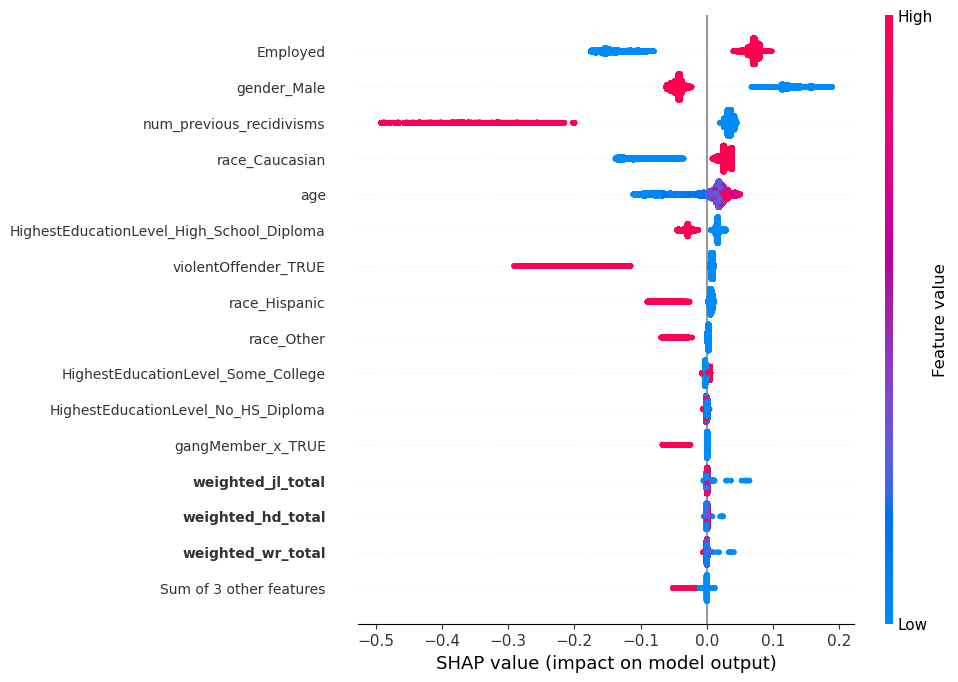

In [21]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Assuming you've already computed your shap_values
# shap_values = model.explain(X)

features_to_bold = ['weighted_jl_total', 'weighted_wr_total', 'weighted_hd_total', 'c_vio']

# Create the beeswarm plot
shap.plots.beeswarm(shap_values1[:,:,0], max_display = 16 ,show = False)

# Get the current y-tick labels (feature names)
yticklabels = plt.gca().get_yticklabels()

# Customize the font properties
bold_font = FontProperties(weight='bold')
regular_font = FontProperties(weight='regular')

# Apply the font properties conditionally
for label in yticklabels:
    if label.get_text() in features_to_bold:
        label.set_fontproperties(bold_font)
    else:
        label.set_fontproperties(regular_font)

# Show the plot
plt.show()

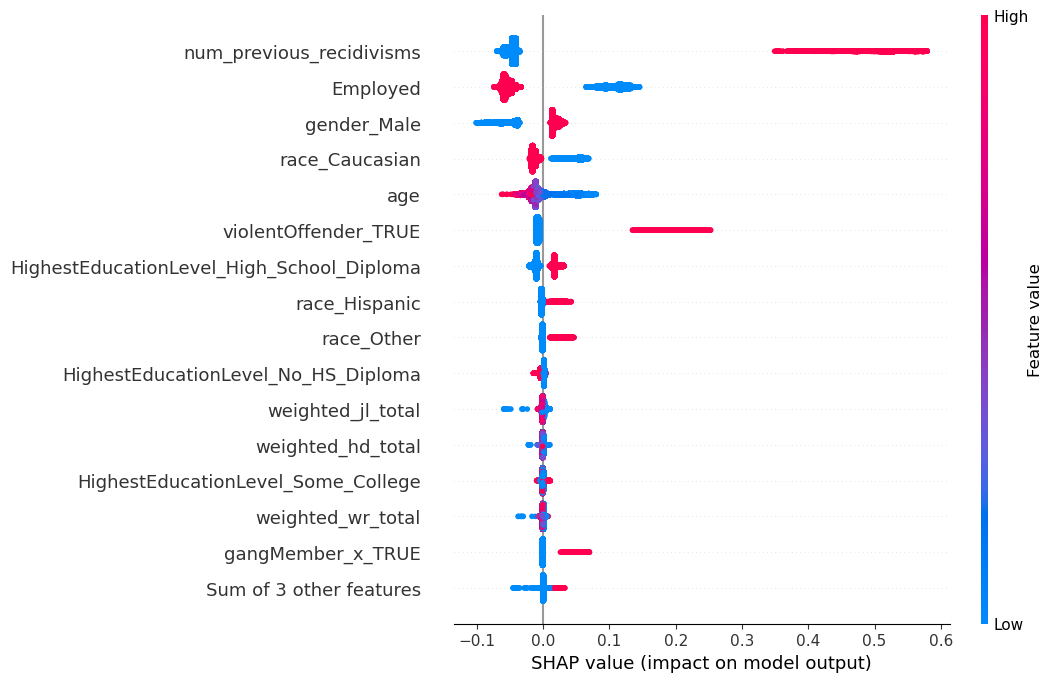

In [72]:
shap.plots.beeswarm(shap_values1[:,:,2], max_display = 16)

In [32]:
with open("shap_values_cap.pkl", 'wb') as file:
    pickle.dump(shap_values1, file)

In [42]:
X_test['placement'] = y_test
X_test.to_csv('test.csv', index = False)

In [37]:
import pickle
with open('explainer.pkl', 'wb') as file:
    pickle.dump(explainer1, file)

In [61]:
with open('shap_values_no_cap.pkl', 'wb') as file:
    pickle.dump(shap_values1, file)

In [81]:
import numpy as np
indices = np.r_[0:1, 2:18, 19:21]

In [27]:
rf2a.feature_names_in_

array(['age', 'num_previous_recidivisms', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_Male',
       'registeredSexOffender_TRUE', 'violentOffender_TRUE',
       'gangMember_x_TRUE', 'homeless_TRUE',
       'HighestEducationLevel_High_School_Diploma',
       'HighestEducationLevel_No_HS_Diploma',
       'HighestEducationLevel_Some_College', 'c_vio', 'Employed',
       'weighted_jl_total', 'weighted_wr_total', 'weighted_hd_total'],
      dtype=object)

In [1]:
import shap
import pickle
shap_values1 = pickle.load(open('shap_values_no_cap.pkl', 'rb'))

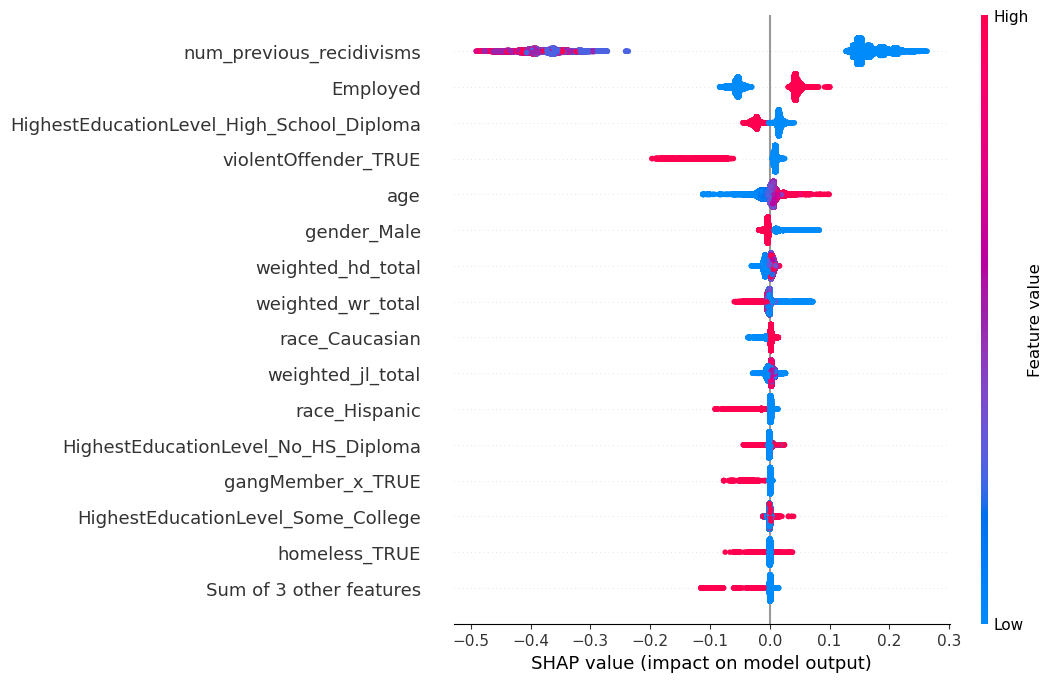

In [9]:
#no_cap
shap.plots.beeswarm(shap_values1[:,:,0], max_display = 16)

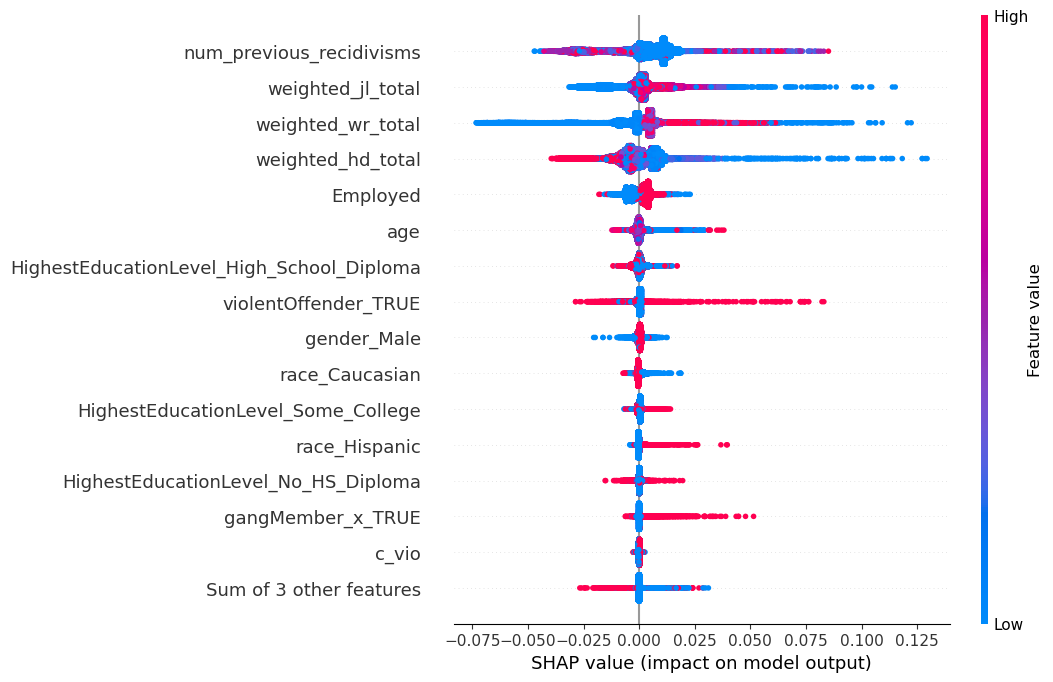

In [11]:
#no_cap
shap.plots.beeswarm(shap_values1[:,:,1], max_display = 16)

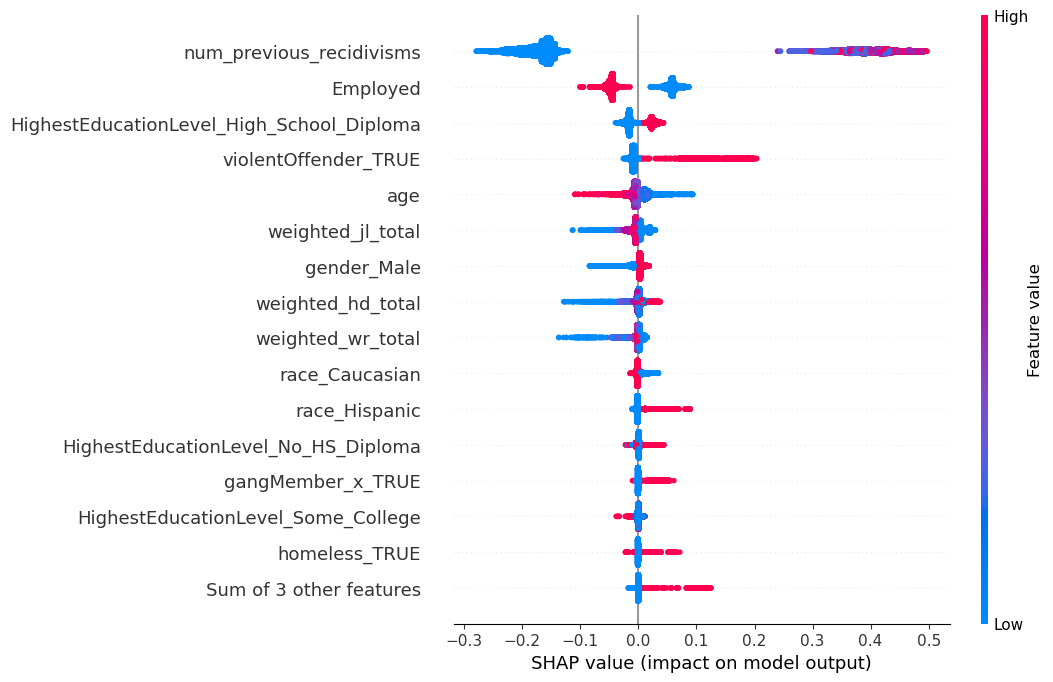

In [12]:
#no_cap
shap.plots.beeswarm(shap_values1[:,:,2], max_display = 16)